# Blood Cell Diagnostics System

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, color, filters, exposure, morphology, measure
import shutil
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, r2_score
import seaborn as sns

In [3]:
original_data_path = 'Data/bloodcells_dataset'
cleaned_data_path = 'Data/bloodcells_dataset_cleaned'
cell_types = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

In [4]:
def get_image_files(folder_path):
    valid_extensions = ('.png', '.jpg', '.jpeg')
    return [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]

In [ ]:
target_shape = (363, 360, 3)
num_images_per_class = 500

if not os.path.exists(cleaned_data_path):
    os.makedirs(cleaned_data_path)

for cell_type in cell_types:
    print(f"\nProcessing {cell_type}\n")
    src_folder = os.path.join(original_data_path, cell_type)
    dest_folder = os.path.join(cleaned_data_path, cell_type)
    
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    image_files = get_image_files(src_folder)
    
    valid_images = []
    for fname in image_files:
        print(f"Processing {fname}")
        src_file_path = os.path.join(src_folder, fname)
        try:
            image = io.imread(src_file_path)
            if image.shape == target_shape:
                valid_images.append(fname)
        except Exception as e:
            print(f"Error processing {src_file_path}: {e}")

    if len(valid_images) < num_images_per_class:
        print(f"Warning: Only found {len(valid_images)} valid images for class {cell_type}.")
        selected_images = valid_images
    else:
        print(f"sampling {cell_type}")
        selected_images = random.sample(valid_images, num_images_per_class)
    
    for fname in selected_images:
        print(f"Finishing up {cell_type}")
        src_file_path = os.path.join(src_folder, fname)
        dest_file_path = os.path.join(dest_folder, fname)
        shutil.copy(src_file_path, dest_file_path)

print("\n\nData cleaning completed.\n")

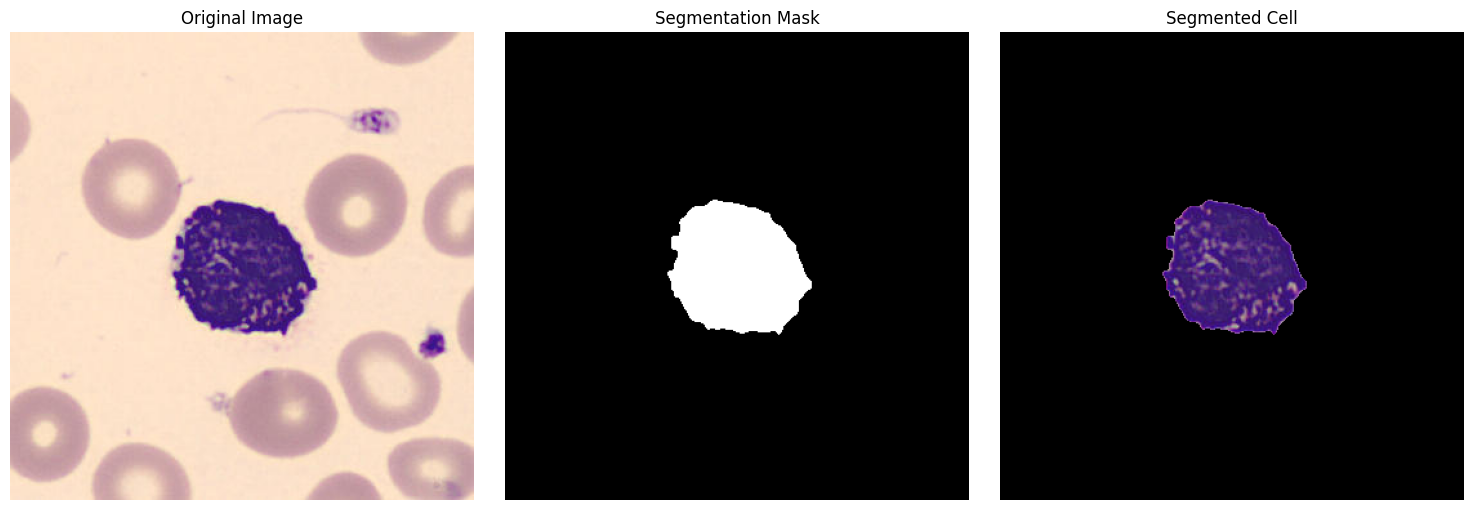

In [12]:
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, util
from skimage.filters import median, gaussian
from skimage.morphology import disk
import numpy as np

def segment_cell(image, sigma=1, median_size=3, min_size=50, hole_area=50):
    """
    Segment the blood cell from the image using additional Gaussian and median filtering.
    
    Parameters:
        image (ndarray): The input RGB image.
        sigma (float): Standard deviation for Gaussian filter.
        median_size (int): Size for the median filter.
        min_size (int): Minimum size for removing small objects.
        hole_area (int): Maximum size of holes to fill.
    
    Returns:
        segmented (ndarray): The segmented image with only the cell.
        mask (ndarray): The binary mask used for segmentation.
    """
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)
    
    # Apply Gaussian filter to smooth out high-frequency noise
    smooth_image = gaussian(gray_image, sigma=sigma)
    
    # Apply median filter to remove salt-and-pepper noise
    smooth_image = median(smooth_image)
    
    # Compute Otsu's threshold on the smoothed image
    thresh = filters.threshold_otsu(smooth_image)
    
    # Create a binary mask; adjust the condition if the cell is brighter than the background
    mask = smooth_image < thresh
    
    # Remove small objects (noise)
    mask = morphology.remove_small_objects(mask, min_size=min_size)
    
    # Fill small holes in the cell region
    mask = morphology.remove_small_holes(mask, area_threshold=hole_area)
    
    # Label connected regions and keep the largest one
    labels = measure.label(mask)
    if labels.max() != 0:
        regions = measure.regionprops(labels)
        largest_region = max(regions, key=lambda r: r.area)
        mask = labels == largest_region.label

    # Apply the mask to the original image
    segmented = image.copy()
    segmented[~mask] = 0  # Set background pixels to black

    return segmented, mask

# Example usage: Load a sample image and segment it.
sample_image_path = 'Data/bloodcells_dataset_cleaned/basophil/BA_580.jpg'  # Update with a valid filename.
sample_image = io.imread(sample_image_path)
segmented, mask = segment_cell(sample_image)

# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Segmentation Mask')
axes[1].axis('off')

axes[2].imshow(segmented)
axes[2].set_title('Segmented Cell')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [13]:
def extract_color_histogram(image, num_bins=8):
    chans = []
    for i in range(3):
        hist, _ = np.histogram(image[:,:,i], bins=num_bins, range=(0, 255))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        chans.extend(hist)
    return np.array(chans)

In [14]:
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9):
    gray = color.rgb2gray(image)
    features, _ = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block, block_norm='L2-Hys',
                      visualize=True, feature_vector=True)
    return features

In [15]:
def extract_lbp_features(image, radius=1, n_points=8, num_bins=10):
    gray = color.rgb2gray(image)
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=num_bins, range=(0, num_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

In [16]:
def extract_gabor_features(image, frequency=0.6):
    gray = color.rgb2gray(image)
    filt_real, filt_imag = gabor(gray, frequency=frequency)
    mean_val = np.mean(filt_real)
    std_val = np.std(filt_real)
    return np.array([mean_val, std_val])

In [ ]:
def extract_features(image):
    segmented, mask = segment_cell(image)
    
    color_feat = extract_color_histogram(segmented, num_bins=8)
    hog_feat = extract_hog_features(segmented, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9)
    lbp_feat = extract_lbp_features(segmented, radius=1, n_points=8, num_bins=10)
    gabor_feat = extract_gabor_features(segmented, frequency=0.6)
    
    features = np.concatenate([color_feat, hog_feat, lbp_feat, gabor_feat])
    return features

cleaned_data_path = 'Data/bloodcells_dataset_cleaned'
cell_types = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

data_records = []

for cell_type in cell_types:
    print(f"\nStarting {cell_type}")
    folder_path = os.path.join(cleaned_data_path, cell_type)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for fname in image_files:
        print(f"Processing {fname}")
        file_path = os.path.join(folder_path, fname)
        try:
            image = io.imread(file_path)
            feats = extract_features(image)
            record = {
                'filename': file_path,
                'label': cell_type
            }
            for idx, val in enumerate(feats):
                record[f'feat_{idx}'] = val
            data_records.append(record)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    print(f"{cell_type} done!\n")

print("\nSaving...")

df = pd.DataFrame(data_records)
df.to_csv('bloodcells_dataset_cleaned_features.csv', index=False)
print(f"Features saved")

In [20]:
feature_vector = pd.read_csv('Data/bloodcells_dataset_cleaned_features.csv')

feature_cols = [col for col in feature_vector.columns if col.startswith('feat_')]
X = feature_vector[feature_cols].values
y = feature_vector['label'].values

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
results = {}

In [25]:
linear_svm = SVC(kernel='linear', random_state=42)
linear_svm.fit(X_train, y_train)
y_pred_linear = linear_svm.predict(X_test)
results['Linear SVM'] = y_pred_linear

In [26]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001]
}
rbf_svm = SVC(kernel='rbf', random_state=42)
grid_svm = GridSearchCV(rbf_svm, param_grid, cv=5, n_jobs=-1)
grid_svm.fit(X_train, y_train)
y_pred_rbf = grid_svm.predict(X_test)
results['Non-linear SVM'] = y_pred_rbf
print("Best parameters for Non-linear SVM:", grid_svm.best_params_)

KeyboardInterrupt: 

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = y_pred_rf

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = y_pred_xgb

In [ ]:
def print_metrics(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n--- {model_name} ---")
    print("MSE:", mse)
    print("R^2:", r2)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()